In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans

%matplotlib inline

In [8]:
# le dropna() permet de supprimer les pays pour lesquels il manque des informations
WGI_complet = pd.read_csv("./src/wgi2019.csv").dropna()
WGI_complet

,Country,Code,Voice and Accountability,Political Stability and Absence of Violence/Terrorism,Government Effectiveness,Regulatory Quality,Rule of Law,Control of Corruption
0,Aruba,ABW,1.294189,1.357372,1.029933,0.857360,1.263128,1.217238
1,Andorra,ADO,1.139154,1.615139,1.908749,1.228176,1.579939,1.234392
2,Afghanistan,AFG,-0.988032,-2.649407,-1.463875,-1.120555,-1.713527,-1.401076
3,Angola,AGO,-0.777283,-0.311101,-1.117144,-0.893871,-1.054343,-1.054683
5,Albania,ALB,0.151805,0.118570,-0.061331,0.274380,-0.411179,-0.528758
...,...,...,...,...,...,...,...,...
209,Serbia,SRB,0.026626,-0.091665,0.019079,0.113867,-0.119070,-0.445551
210,South Africa,ZAF,0.670388,-0.217931,0.367380,0.156172,-0.076408,0.084924
211,"Congo, Dem. Rep.",ZAR,-1.365966,-1.808007,-1.627429,-1.509667,-1.786088,-1.538931
212,Zambia,ZMB,-0.286199,-0.102216,-0.675215,-0.554269,-0.462069,-0.640345


### ACP

On va `fit()` les données (variables uniquement quantitatives).

Si l'on souhaite une ACP normée (ce qui n'est pas le cas ici), il nous faut standardiser les données en amont, avec par exemple la fonction scale() du sous-module preprocessing (importée aussi ici). Bien évidemment, il ne faut passer que des variables quantitatives, sans données manquantes.

In [9]:
# suppression des colonnes non numériques
WGI_num = WGI_complet.drop(columns = ["Country", "Code"])
pca = PCA()
pca.fit(WGI_num)

PCA()

#### Variance expliquée

L'objet `pca` comprend maintenant un certain nombre d'objets et de fonctions. Le premier objet est le tableau des variances expliquées (`explained_variance_` - proportionnelles aux valeurs propres) par chaque dimension, et le ratio (proportion) de variance expliquée par dimension (`explained_variance_ratio_`).

In [10]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[5.04959218 0.41467898 0.30759716 0.12165034 0.04965011 0.04069217]
[0.84386857 0.06929957 0.05140446 0.02032974 0.00829734 0.00680032]


Bien évidemment, il est possible (et préférable) de faire un tableau récapitulatif, avec les variances expliquées, les proportions de variance expliquée simples et cumulées. Voici un petit code permettant de faire ceci.

In [16]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,5.049592,84.0,84.0
1,Dim2,0.414679,7.0,91.0
2,Dim3,0.307597,5.0,96.0
3,Dim4,0.121650,2.0,98.0
4,Dim5,0.049650,1.0,99.0
5,Dim6,0.040692,1.0,100.0


L'idée est de représenter graphiquement ces proportions de variances expliquées (qu'on passe en pourcentage par convenance).

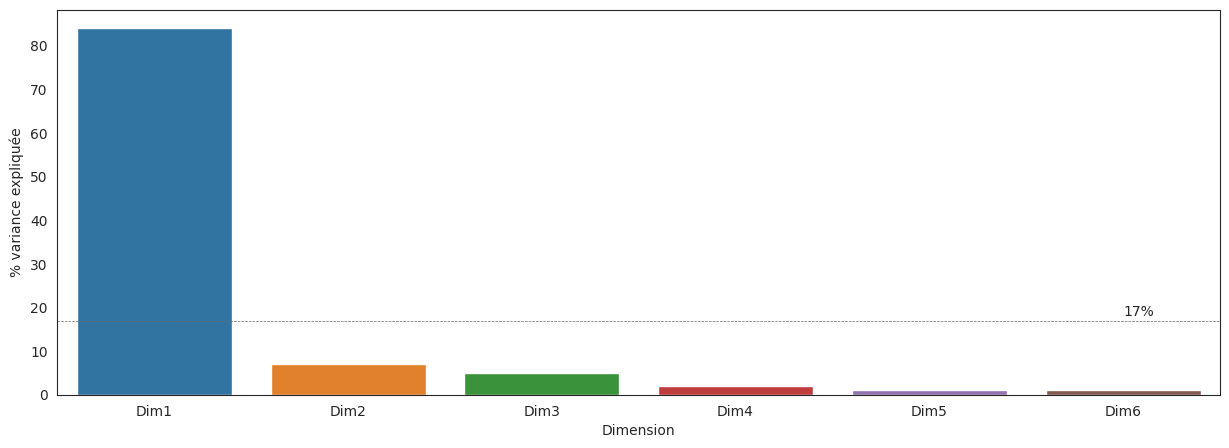

In [17]:
plt.figure(figsize=(15,5)) 
sns.barplot(data=eig, x="Dimension", y="% variance expliquée")
plt.text(5, 18, "17%")
plt.axhline(y=17, linewidth=.5, color="dimgray", linestyle="--") # ligne 17 = 100 / 6 (nb dimensions)
plt.show();

On remarque ici qu'avec seulement deux dimensions suffisent à expliquer 91 % de la variance des données.

### Représentation des individus

Nous allons maintenant calculer les coordonnées des pays sur les dimensions, avec la fonction `transform()` de l'objet **pca**.

In [18]:
WGI_pca = pca.transform(WGI_num)

Afin de manipuler plus facilement l'objet obtenu par la suite, nous allons créer un dataframe en ne prenant que les deux premières dimensions, ainsi que le nom des pays

In [19]:
# Transformation en dataframe
WGI_pca_df = pd.DataFrame({
    "Dim1" : WGI_pca[:,0], 
    "Dim2" : WGI_pca[:,1],
    "Country" : WGI_complet["Country"]
})

# Résultat (premières lignes)
WGI_pca_df.head()

,Dim1,Dim2,Country
0,-2.921523,0.503627,Aruba
1,-3.630601,0.075195,Andorra
2,3.704414,-0.846353,Afghanistan
3,2.083839,0.446336,Angola
5,0.137824,0.175896,Albania


Il est maintenant possible de représenter les données sur le premier plan factoriel. Dans ce graphique, il est important de noter le pourcentage de variance expliquée.

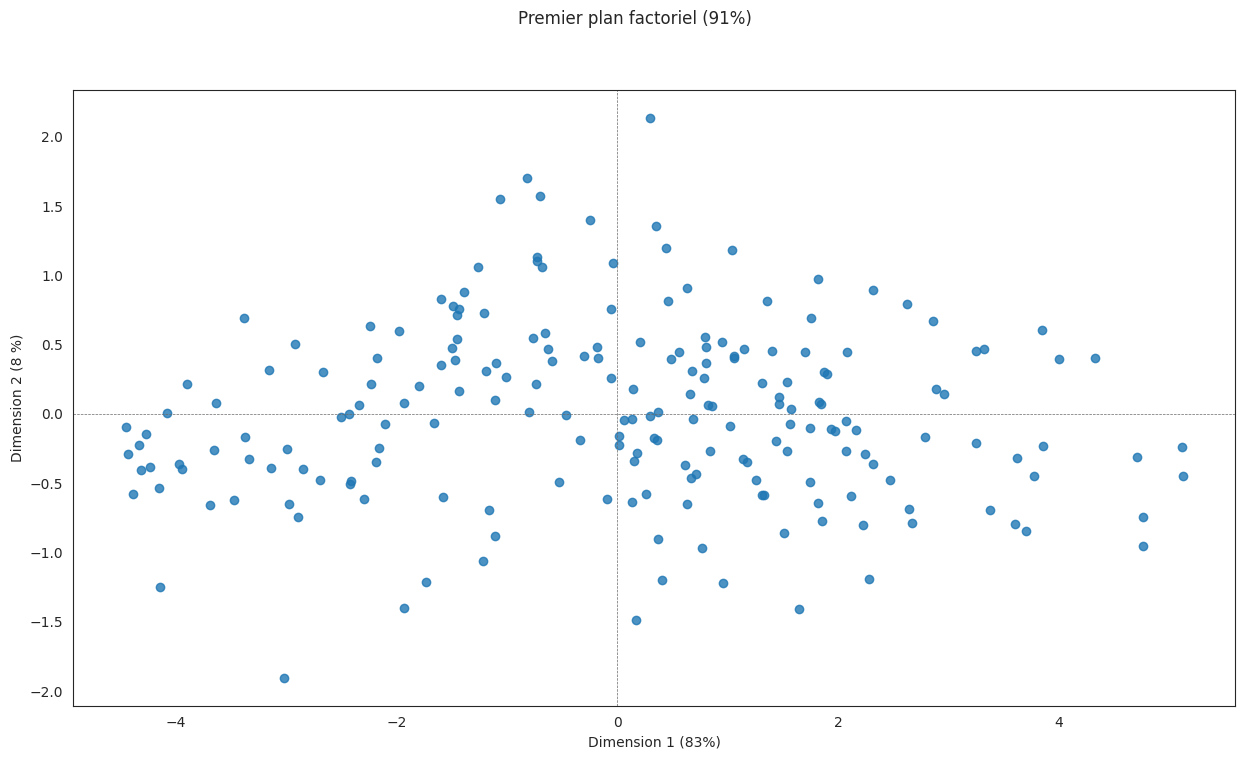

In [20]:
plt.figure(figsize=(15,8))
plt.axvline(x=0, linewidth=.5, color="dimgray", linestyle="--")
plt.axhline(y=0, linewidth=.5, color="dimgray", linestyle="--")
sns.regplot(data=WGI_pca_df, x="Dim1", y="Dim2", fit_reg=False)
plt.xlabel("Dimension 1 (83%)") # modification du nom de l'axe X
plt.ylabel("Dimension 2 (8 %)") # idem pour axe Y
plt.suptitle("Premier plan factoriel (91%)") # titre général
plt.show()

Dans ce même graphique, on veut repérer les individus aux extrêmes. Ci-dessous, nous affichons donc les noms des pays ayant des valeurs absolues élevées pour chaque composante.

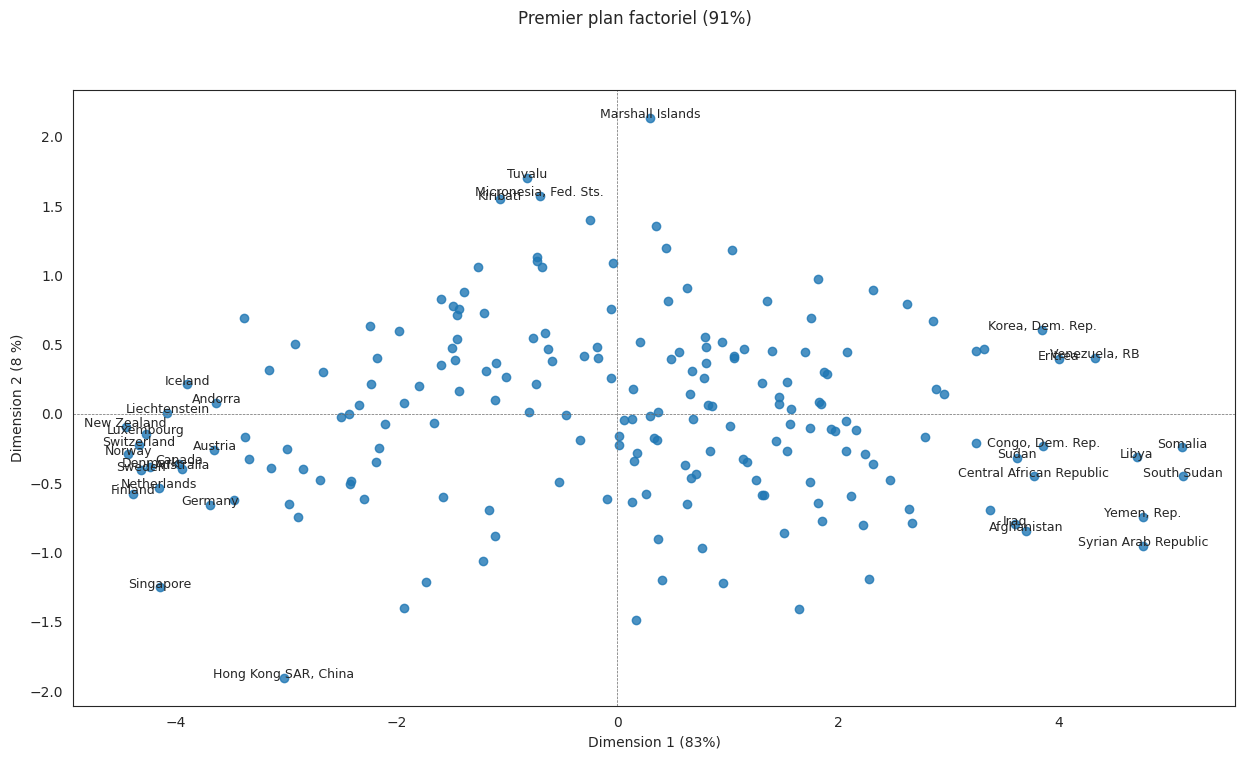

In [21]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots(figsize=(15,8))
plt.axvline(x=0, linewidth=.5, color="dimgray", linestyle="--")
plt.axhline(y=0, linewidth=.5, color="dimgray", linestyle="--")

# l'option ax permet de placer les points et le texte sur le même graphique
sns.regplot(data=WGI_pca_df, x="Dim1", y="Dim2", fit_reg=False, ax=ax)

# boucle sur chaque pays
for k in WGI_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une des 2 dimensions importantes 
    # (valeurs choisies empiriquement)
    if (abs(k[1]['Dim1']) > 3.5) | (abs(k[1]['Dim2']) > 1.5):
        ax.annotate(k[1]["Country"], (k[1]['Dim1'], k[1]['Dim2']), fontsize=9, ha="center")
plt.xlabel("Dimension 1 (83%)") 
plt.ylabel("Dimension 2 (8 %)")
plt.suptitle("Premier plan factoriel (91%)")
plt.show()

#### Représentation des variables

Lorsqu'on réalise une ACP, surtout dans un contexte exploratoire (et non de compression), il est absolument nécessaire de décrire les axesà partir des variables, afin de comprendre ce qu'ils représentent. Pour cela, nous devons réaliser le *cercle des corrélations*. Malheureusement, il faut le réaliser à la main.

In [22]:
n = WGI_num.shape[0]                         # nb individus
p = WGI_num.shape[1]                         # nb variables
eigval = (n-1) / n * pca.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval)                # racine carrée des valeurs propres
corvar = np.zeros((p,p))                     # matrice vide pour avoir les coordonnées

for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': WGI_num.columns, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

,id,COR_1,COR_2
0,Voice and Accountability,-0.846195,0.313757
1,Political Stability and Absence of Violence/Te...,-0.831344,0.421281
2,Government Effectiveness,-0.949948,-0.239510
3,Regulatory Quality,-0.935462,-0.260429
4,Rule of Law,-0.973515,-0.085161
5,Control of Corruption,-0.944562,-0.065300


Une fois ces coordonnées récupérées, on peut donc afficher ce cercle des corrélations comme ci-dessous.

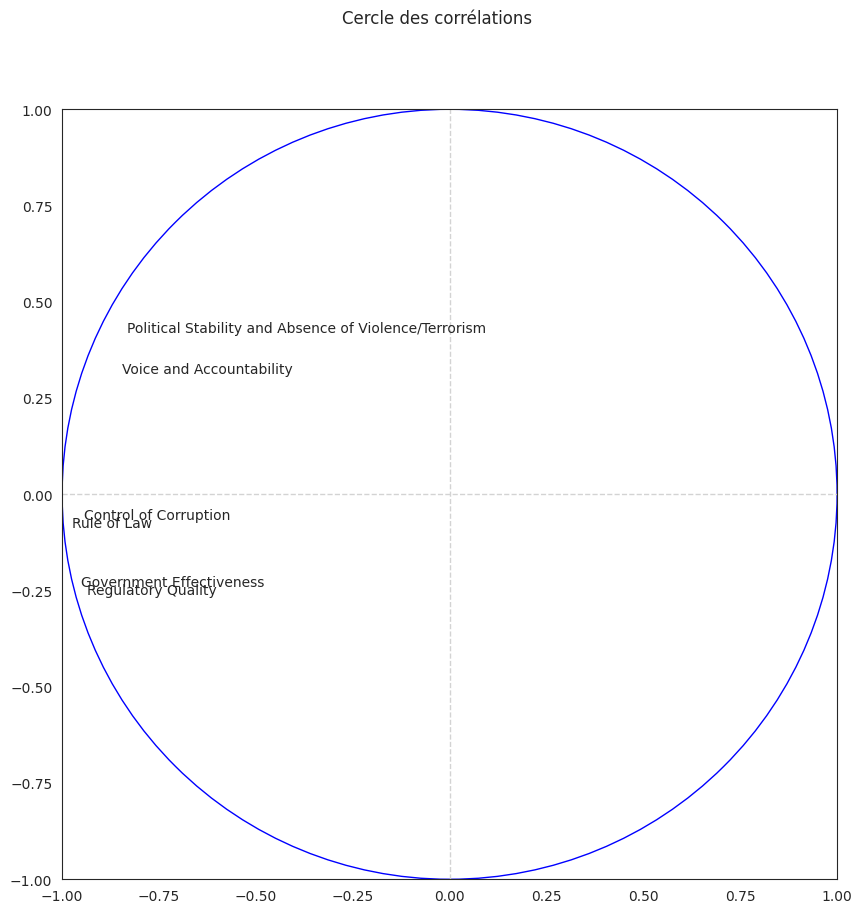

In [23]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize=(10, 10))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Ajout des axes
axes.axvline(x=0, color='lightgray', linestyle='--', linewidth=1)
axes.axhline(y=0, color='lightgray', linestyle ='--', linewidth=1)

# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])

# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0), 1, color='blue',fill=False))
plt.show();

Ici, on va en déduire que l'axe 1 oppose à gauche les pays avec une forte valeur dans tous les indicateurs (ils sont tous à gauche), et à droite les pays à faible valeur pour ces indicateurs.

L'axe 2 semble opposer les pays avec une valeur positive pour les indicateurs sur la statibilité politique et la prise en compte de l'avis des citoyens en haut, avec les pays avec une valeur négative pour ces 2 indicateurs en bas.

Vous pouvez revenir sur le graphique des pays pour mieux comprendre.

### Classification

Nous allons ici réaliser une classification non supervisée. Bien évidemment, ici, nous pouvons peut-être supposé qu'une partition en 6 classes (1 par continent) est possible. Mais nous n'avons pas de réelle idée de ce nombre de classes. Pour l'estimer, nous allons utiliser 2 techniques.

#### Classification Ascendante Hiérarchique (CAH)

La première possibilité est d'utiliser la CAH (avec le critère de Ward), afin d'obtenir un dendrogramme représentant les regroupements 2 à 2 de toutes les classes.

Tout d'abord, nous importons la méthode, puis nous l'appliquons. Ici, on indique qu'on ne souhaite pas réaliser de découpage au préalable, et donc qu'on souhaite garder toute la hiérarchie.